In [1]:
import bittensor as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/isabella/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

class Pool:

    # Initialize the pool with initial internal reserves
    # -- (tao_in): Amount of TAO in the pool.
    # -- (alpha_in): Amount of ALPHA in the pool.
    # -- (alpha_out): Amount of ALPHA oustanding (in the network)
    def __init__(self, tao_in:float, alpha_in:float, alpha_out:float, name:str = "alpha"):
        self.name = name
        self.tao_in = tao_in 
        self.alpha_in = alpha_in
        self.alpha_out = alpha_out
        self.k = self.tao_in * self.alpha_in
        
    # Helpers
    def __str__(self): return f"P( {self.tao_in}, {self.alpha_in}, {self.alpha_out}, {self.price})"
    def __repr__(self): return self.__str__()
    @property
    def price(self): return self.tao_in/self.alpha_in

    @property
    def market_cap(self): return self.price * self.alpha_out
    
    # Return the amount of ALPHA if we were to buy with the passed TAO (does not change the pool)
    def simbuy(self, tao:float ) -> float:
        new_tao_in = self.tao_in + tao
        new_alpha_in = self.k / new_tao_in
        alpha_out = self.alpha_in - new_alpha_in
        return alpha_out
    
    # Return the amount of TAO if were to sell with the passed ALPH (does not change the pool)
    def simsell(self, alpha: float) -> float:
        new_alpha_in = self.alpha_in + alpha
        new_tao_in = self.k / new_alpha_in
        tao_out = self.tao_in - new_tao_in
        return tao_out
            
    # Perform a buy operation with the passed TAO and return the ALPHA bought ( changes the pool reserves )
    def buy(self, tao:float ) -> float:
        new_tao_in = self.tao_in + tao
        new_alpha_in = self.k / new_tao_in
        alpha_out = self.alpha_in - new_alpha_in
        self.alpha_out += alpha_out
        self.tao_in = new_tao_in
        self.alpha_in = new_alpha_in
        return alpha_out
    
    # Perform a sell operation with the passed ALPHA and return the TAO bought (changes the pool reserves )
    def sell(self, alpha: float) -> float:
        new_alpha_in = self.alpha_in + alpha
        new_tao_in = self.k / new_alpha_in
        tao_out = self.tao_in - new_tao_in
        self.alpha_out -= alpha
        self.alpha_in = new_alpha_in
        self.tao_in = new_tao_in
        return tao_out
    
    # Adds TAO, ALPHA and ALPHA_OUTSTANDING to the pool changing the K param. 
    def inject( self, tao_in: float, alpha_in: float, alpha_out:float ):
        self.tao_in += tao_in
        self.alpha_in += alpha_in
        self.alpha_out += alpha_out
        self.k = self.tao_in * self.alpha_in


## Init Slippage

In [3]:
# theory: slippage = difference between k and alpha_out

df = []
portions = np.arange(0, 1, 0.1)

p = Pool(1000, 1, 1000)
days = 1000 # 3 years
tempo = 100
for step in range (round(7200 / tempo * days)):
    p.inject(0.015 * tempo, 1*tempo, 1*tempo)
    if step == 72 * 0.5:
        p.buy(100)
        print("boutght 100")
    
    if step == 72 :
        p.sell(100)
        print("sold 100")
    
    for portion in portions:    
        tao_bought = p.simsell(p.alpha_out * portion)
        tao_ownership = p.tao_in * portion
        slippage = 1 - tao_bought / tao_ownership
        df.append({
            'portion': portion,
            'alpha_sell': p.alpha_out * portion,
            'tao_bought': tao_bought,
            'tao_ownership': tao_ownership,
            'p_tao_in': p.tao_in,
            'p_alpha_in': p.alpha_in,
            'p_alpha_out': p.alpha_out,
            'slippage': slippage,
            'tempo': step,
            'block': step * tempo
        })

df = pd.DataFrame(df)
df['est_slippage'] = 1 - df.p_alpha_out / (df.p_alpha_in + df.alpha_sell)
df['p_alpha_in_rounded'] = round(df.p_alpha_in / 100_000) * 100_000
df.sort_values('block', inplace=True)

/tmp/ipykernel_2181190/4123577046.py:22: RuntimeWarning: invalid value encountered in scalar divide
  slippage = 1 - tao_bought / tao_ownership


boutght 100
sold 100


/tmp/ipykernel_2181190/4123577046.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  slippage = 1 - tao_bought / tao_ownership


Text(0.5, 1.0, 'Slippage convergence at the start of the SN')

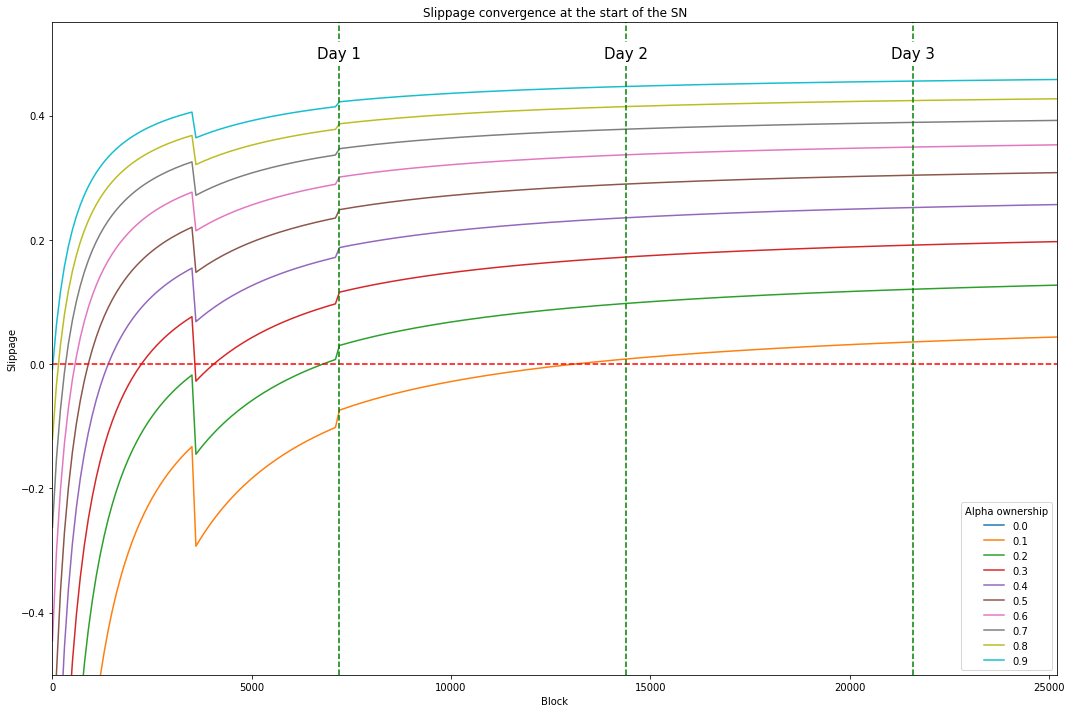

In [4]:
plt.figure(figsize=(18, 12))
for portion in portions:
    _df = df[df.portion == portion]
    plt.plot(_df.block, _df.slippage, label = round(portion, 1))

plt.axhline(y = 0, color = 'r', linestyle = '--') 
plt.axvline(x = 7200, color = 'green', linestyle = '--') 
plt.axvline(x = 7200 * 2, color = 'green', linestyle = '--') 
plt.axvline(x = 7200 * 3, color = 'green', linestyle = '--') 

plt.text(7200, 0.5, 'Day 1', fontsize=15, va='center', ha='center', backgroundcolor='w')
plt.text(7200 * 2, 0.5, 'Day 2', fontsize=15, va='center', ha='center', backgroundcolor='w')
plt.text(7200 * 3, 0.5, 'Day 3', fontsize=15, va='center', ha='center', backgroundcolor='w')

plt.xlim(0, 7200 * 3.5)
plt.ylim(-0.5, 0.55)
plt.legend(title = "Alpha ownership")
plt.xlabel('Block')
plt.ylabel('Slippage')
plt.title("Slippage convergence at the start of the SN")

## Init Price 

In [5]:
df = []
emissions = np.arange(0.05, 0.2, 0.05)

days = 1000 # 3 years
tempo = 100
for emission in emissions:    
    p = Pool(1000, 1,1000)
    for step in range (round(7200 / tempo * days)):
        p.inject(emission * tempo, 1*tempo, 1*tempo)
        if step == 72 * 0.5:
            p.buy(100)
            print("boutght 100")
        df.append({
            'p_tao_in': p.tao_in,
            'p_alpha_in': p.alpha_in,
            'p_alpha_out': p.alpha_out,
            'tempo': step,
            'block': step * tempo,
            'emission': emission,
            'price': p.price
        })

df = pd.DataFrame(df)

boutght 100
boutght 100
boutght 100
boutght 100


Text(0.5, 1.0, 'Price convergence at the start of the SN')

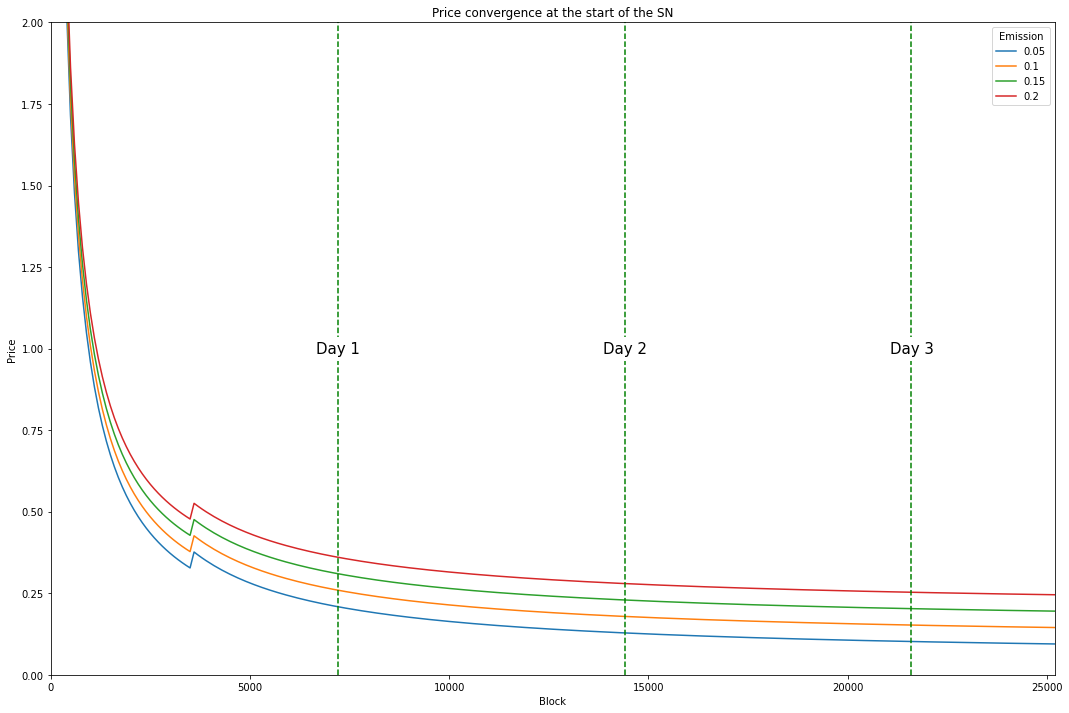

In [6]:
plt.figure(figsize=(18, 12))
for emission in emissions:
    _df = df[df.emission == emission]
    plt.plot(_df.block, _df.price, label = round(emission, 2))

plt.axvline(x = 7200, color = 'green', linestyle = '--') 
plt.axvline(x = 7200 * 2, color = 'green', linestyle = '--') 
plt.axvline(x = 7200 * 3, color = 'green', linestyle = '--') 

plt.text(7200, 1, 'Day 1', fontsize=15, va='center', ha='center', backgroundcolor='w')
plt.text(7200 * 2, 1, 'Day 2', fontsize=15, va='center', ha='center', backgroundcolor='w')
plt.text(7200 * 3, 1, 'Day 3', fontsize=15, va='center', ha='center', backgroundcolor='w')

plt.xlim(0, 7200 * 3.5)
plt.ylim(0, 2)
plt.legend(title = "Emission")
plt.xlabel('Block')
plt.ylabel('Price')
plt.title("Price convergence at the start of the SN")

## Init price change with buying 

In [7]:
# there are 20 ppl 
# group A: 10 ppl with 70 tao each 
# group B: 10 ppl with 30 tao each 
# While group A delegate all to SN 1; group B delegate all to SN 2 

df = []

days = 1000 # 3 years
tempo = 100
alphas = []
betas = []

for buying_days in [3, 7, 14, 30]:
    tao_sold_per_tempo = 7_000_000 * 0.2 / buying_days/ (7200 / tempo)
    SN1 = Pool(1000, 1, 1000, name = "SN1")
    SN2 = Pool(1000, 1, 1000, name = "SN2")
    SNs = [SN1, SN2]
    
    for step in range (round(7200 / tempo * days)):
        total_tao = sum([p.tao_in for p in SNs])
        
        for SN in SNs:    
            SN.inject(SN.tao_in/ total_tao * tempo, 1*tempo, 1*tempo)
            
            if step > 10 and (step < 72 * buying_days):
                if SN.name == 'SN1':
                    sn_tao_sold_per_tempo = tao_sold_per_tempo * 4
                else:
                    sn_tao_sold_per_tempo = tao_sold_per_tempo
                
                alpha_bought = SN.buy(sn_tao_sold_per_tempo)
            else:

                alpha_bought = None
                sn_tao_sold_per_tempo = None

            result = {
                'buying_days': buying_days,
                'SN': SN.name,
                'emission': SN.tao_in/total_tao,
                'p_tao_in': SN.tao_in,
                'p_alpha_in': SN.alpha_in,
                'p_alpha_out': SN.alpha_out,
                'tempo': step,
                'block': step * tempo,
                'price': SN.price,
                'total_tao': total_tao, 
                'alpha_bought': alpha_bought,
                'tao_sold': sn_tao_sold_per_tempo
            }
            df.append(result)

df = pd.DataFrame(df)

In [8]:
df[~df.tao_sold.isna()]

,buying_days,SN,emission,p_tao_in,p_alpha_in,p_alpha_out,tempo,block,price,total_tao,alpha_bought,tao_sold
22,3,SN1,8.879331,2.752593e+04,69.810549,3331.189451,11,1100,394.294649,3.100000e+03,1131.189451,25925.925926
23,3,SN2,2.606930,8.081481e+03,237.778185,3163.221815,11,1100,33.987481,3.100000e+03,963.221815,6481.481481
24,3,SN1,1.503315,5.352916e+04,87.565730,3513.434270,12,1200,611.302568,3.560741e+04,82.244819,25925.925926
25,3,SN2,0.409624,1.458566e+04,187.678485,3413.321515,12,1200,77.716202,3.560741e+04,150.099700,6481.481481
26,3,SN1,1.167641,7.953367e+04,126.424137,3674.575863,13,1300,629.101930,6.811481e+04,61.141594,25925.925926
...,...,...,...,...,...,...,...,...,...,...,...,...
436315,30,SN2,0.200260,1.436328e+06,109068.363208,323532.636792,2157,215700,13.169062,7.172330e+06,49.239707,648.148148
436316,30,SN1,0.800206,5.742015e+06,109008.101760,323792.898240,2158,215800,52.675120,7.175670e+06,49.240774,2592.592593
436317,30,SN2,0.200260,1.436996e+06,109119.123502,323681.876498,2158,215800,13.169059,7.175670e+06,49.239707,648.148148
436318,30,SN1,0.800206,5.744687e+06,109058.860986,323942.139014,2159,215900,52.675110,7.179011e+06,49.240774,2592.592593


1        NaN
3        NaN
5        NaN
7        NaN
9        NaN
          ..
143991   NaN
143993   NaN
143995   NaN
143997   NaN
143999   NaN
Name: tao_sold, Length: 72000, dtype: float64

 11371.464652396997
144001   NaN
144003   NaN
144005   NaN
144007   NaN
144009   NaN
          ..
287991   NaN
287993   NaN
287995   NaN
287997   NaN
287999   NaN
Name: tao_sold, Length: 72000, dtype: float64 25682.014614202162
288001   NaN
288003   NaN
288005   NaN
288007   NaN
288009   NaN
          ..
431991   NaN
431993   NaN
431995   NaN
431997   NaN
431999   NaN
Name: tao_sold, Length: 72000, dtype: float64 50583.43932153854
432001   NaN
432003   NaN
432005   NaN
432007   NaN
432009   NaN
          ..
575991   NaN
575993   NaN
575995   NaN
575997   NaN
575999   NaN
Name: tao_sold, Length: 72000, dtype: float64 106831.11620504947


Text(0.5, 1.0, 'Price convergence at the start of the SN, with buying')

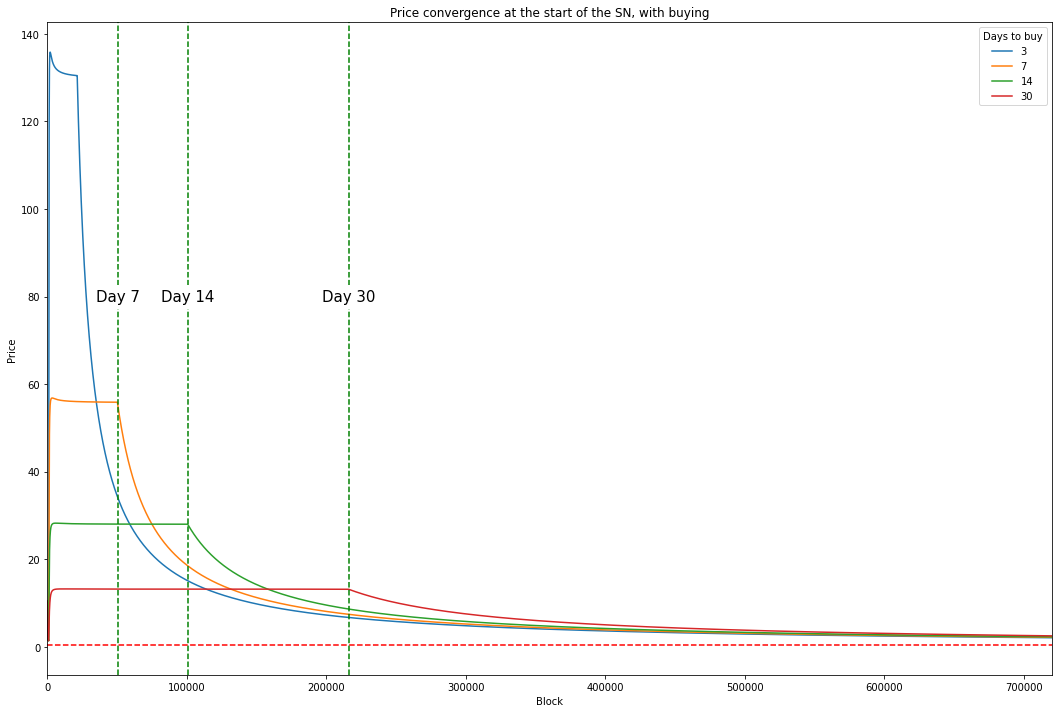

In [9]:
plt.figure(figsize=(18, 12))
# for SN in SNs:
for SN in [SN2]:
    for buying_days in df.buying_days.unique():
        _df = df[df.SN == SN.name]
        _df = _df[_df.buying_days == buying_days]
        print(_df.tao_sold, _df.alpha_bought.sum())
        plt.plot(_df.block, _df.price, label = buying_days)

plt.axhline(y = 0.338247, color = 'red', linestyle = '--') 

plt.axvline(x = 7200 * 7, color = 'green', linestyle = '--') 
plt.axvline(x = 7200 * 14, color = 'green', linestyle = '--') 
plt.axvline(x = 7200 * 30, color = 'green', linestyle = '--') 

plt.text(7200 * 7, 80, 'Day 7', fontsize=15, va='center', ha='center', backgroundcolor='w')
plt.text(7200 * 14, 80, 'Day 14', fontsize=15, va='center', ha='center', backgroundcolor='w')
plt.text(7200 * 30, 80, 'Day 30', fontsize=15, va='center', ha='center', backgroundcolor='w')

plt.xlim(0, 7200 * 100)
plt.legend(title = "Days to buy")
plt.xlabel('Block')
plt.ylabel('Price')
plt.title("Price convergence at the start of the SN, with buying")

In [10]:
7_000_000 * 0.2 / 7 / 72

2777.777777777778

## Slippage and ownership

In [11]:
tao_in = 100

df = []
for p1 in np.arange(0, 3, 0.5):
    for p2 in np.arange(0, 1, 0.1):
        alpha_in = 100_000
        alpha_out = alpha_in * p1
        alpha_sell = alpha_out * p2

        p = Pool(tao_in, alpha_in, alpha_out)

        tao_bought = p.simsell(alpha_sell)
        tao_ownership = p.tao_in * p2
        slippage = 1 - tao_bought / tao_ownership

        exp_slippage = 1 - alpha_out / (alpha_in + alpha_sell)
        df.append({
            'p1': p1,
            'p2': round(p2, 1),
            'alpha_in': alpha_in,
            'alpha_out': alpha_out,
            'alpha_sell': alpha_sell,
            'slippage': slippage,
            'exp_slippage': exp_slippage,
        })
df = pd.DataFrame(df)

/tmp/ipykernel_2181190/1739015195.py:14: RuntimeWarning: invalid value encountered in scalar divide
  slippage = 1 - tao_bought / tao_ownership


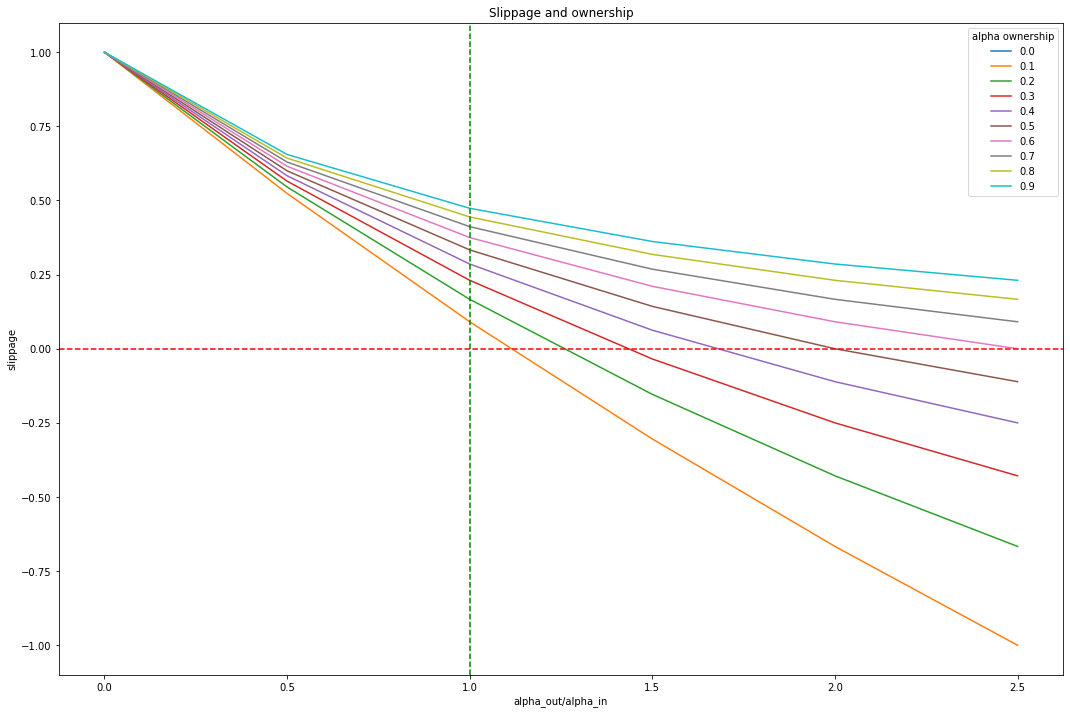

In [12]:
# when selling alpha, slippage depends on alpha_in
plt.figure(figsize=(18, 12))
# for p1 in df.p1.unique():
for p2 in df.p2.unique():
    _df = df[df.p2 == p2]
    # _df = _df[_df.slippage > 0]
    plt.plot(_df.p1, _df.slippage, label = p2)
    plt.xlabel('alpha_out/alpha_in')
    plt.ylabel('slippage')
    plt.legend(title = 'alpha ownership')

plt.title("Slippage and ownership")
plt.axhline(y = 0, color = 'r', linestyle = '--') 
plt.axvline(x = 1, color = 'green', linestyle = '--') 

In [13]:
tao_in = 100

df = []
for p1 in np.arange(0, 3, 0.05):
    for slippage in np.arange(-1, 1, 0.2):
        p2 = 1 /(1 - slippage) - 1/ p1 
        df.append({
            'p1': p1,
            'p2': p2,
            'slippage': slippage,
        })

df = pd.DataFrame(df)

/tmp/ipykernel_2181190/279597381.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  p2 = 1 /(1 - slippage) - 1/ p1


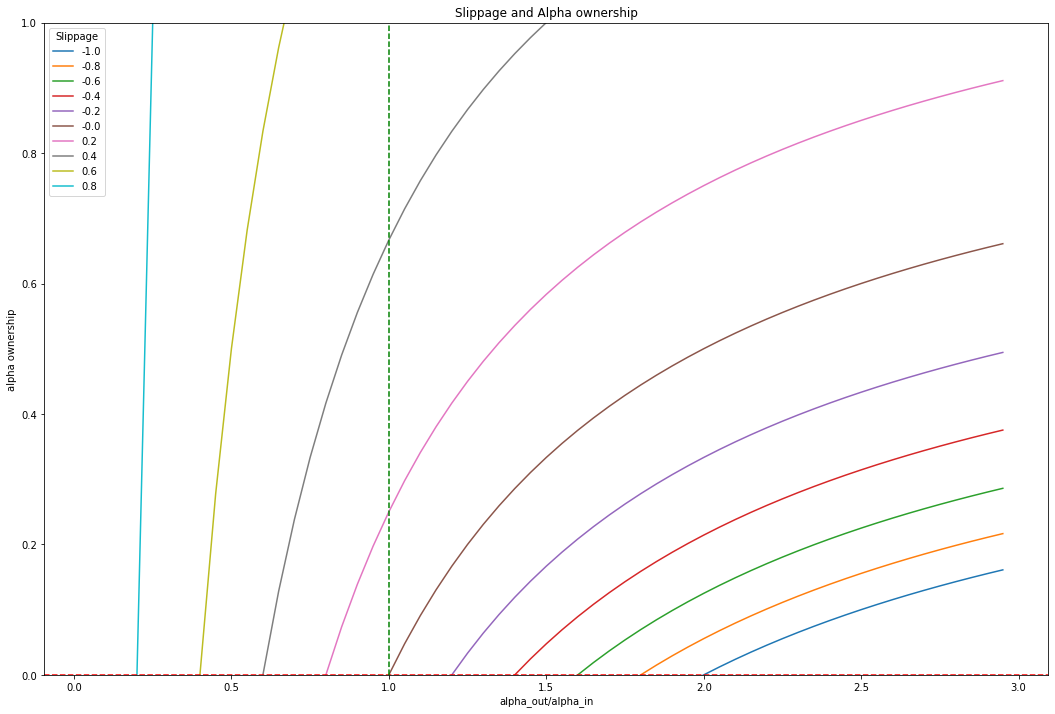

In [14]:
# when selling alpha, slippage depends on alpha_in
plt.figure(figsize=(18, 12))
# for p1 in df.p1.unique():
for slippage in df.slippage.unique():
    _df = df[df.slippage == slippage]
    # _df = _df[_df.slippage > 0]
    if slippage == 0:
        plt.plot(_df.p1 , _df.p2 , label = round(slippage, 1))
    else:
        plt.plot(_df.p1 , _df.p2 , label = round(slippage, 1))

    plt.xlabel('alpha_out/alpha_in')
    plt.ylabel('alpha ownership')
    plt.legend(title = 'Slippage')

plt.ylim(0, 1)
plt.title("Slippage and Alpha ownership")
plt.axhline(y = 0, color = 'r', linestyle = '--') 
plt.axvline(x = 1, color = 'green', linestyle = '--') 

## Dump 


In [15]:
import torch

class wallet:
    def __init__(self, tao, name = "A"):
        self.name = name
        self.tao = tao
        self.alpha = {}

    def join_pool(self, pool):    
        self.alpha[pool.name] = 0

    def lock_pool(self, pool):
        self.tao -= 1000
        self.alpha[pool.name] += 1000

    def emit(self, pool, alpha):
        self.alpha[pool.name] += alpha

    def buy(self, pool, tao):
        alpha = pool.buy(tao)
        self.tao -= tao
        self.alpha[pool.name] += alpha
        return alpha

    def sell(self, pool, alpha):
        tao = pool.sell(alpha)
        self.alpha[pool.name] -= alpha
        self.tao += tao
        return tao

    def simbuy(self, pool, tao):
        return pool.simbuy(tao)
    
    def simsell(self, pool, alpha):
        return pool.simsell(alpha)

    def __str__(self):
        return f"Wallet {self.name}: {self.tao}, {self.alpha}"

    def __repr__(self):
        return self.__str__()

class wallets:
    def __init__(self, wallets, pools):
        self.wallets = wallets
        self.pools = pools

        for wallet in wallets:
            for pool in pools:
                wallet.join_pool(pool)  
    
    def global_tao(self):
        alpha_map = torch.zeros(len(self.wallets), len(self.pools))
        for y, wallet in enumerate(self.wallets):
            for x, pool in enumerate(self.pools):
                alpha_map[y, x] = wallet.alpha[pool.name]

        alpha_map = alpha_map / alpha_map.sum(0)
        global_tao = (alpha_map * torch.tensor([ pool.tao_in for pool in self.pools])).sum(0)
        return global_tao / global_tao.sum()

# setup scenario
adv_tao_portion = 0.2

issued_tao = 100_000_000
adv_wallet = wallet(adv_tao_portion * issued_tao, name = "adv")
honest_wallet = wallet((1 - adv_tao_portion) * issued_tao, name = "honest")
adv_pool = Pool(1000, 1000, 1000, 'alpha')
honest_pool = Pool(1000, 1000, 1000, 'beta')

wallets = wallets([adv_wallet, honest_wallet], [adv_pool, honest_pool])

# adv create dummy SN
adv_wallet.lock_pool(adv_pool)
adv_wallet.buy(adv_pool, adv_wallet.tao)

# honest_pool
honest_wallet.lock_pool(honest_pool)
honest_wallet.buy(honest_pool, honest_wallet.tao)

global_tao_step = []

# run a tempo where 50% dividend goes to global and 50% to adv, 100% incentive goes to adv 
def tempo(adv_pool, honest_pool, wallets, adv_wallet, honest_wallet):
    _tempo = 100
    # tempo for adv_pool
    adv_pool.inject(adv_pool.tao_in/(honest_pool.tao_in + adv_pool.tao_in) * _tempo, 1 * _tempo, 1 * _tempo)
    adv_wallet.emit(adv_pool, (
        0.82 * 0.5 * 0.5 * wallets.global_tao()[0] + # emission from global dividend
        0.82 * 0.5 * 0.5 + # emission from 100% alpha ownership 
        0.82 * 0.5 + # emission from incentive
        0.18 # emission from SN owner role 
        ) * _tempo
    )
    honest_wallet.emit(adv_pool, (
        0.82 * 0.5 * 0.5 * wallets.global_tao()[1] # emission from global dividend
        ) * _tempo
    )

    # tempo for honest_pool
    honest_pool.inject(honest_pool.tao_in / (honest_pool.tao_in + adv_pool.tao_in) * _tempo, 1 * _tempo, 1 * _tempo)
    adv_wallet.emit(honest_pool, (
        0.82 * 0.5 * 0.5 * wallets.global_tao()[0] # emission from global dividend
        ) * _tempo
    )
    honest_wallet.emit(honest_pool, (
        0.82 * 0.5 * 0.5 * wallets.global_tao()[1] + # emission from global dividend
        0.82 * 0.5 * 0.5 + # emission from 100% alpha ownership 
        0.82 * 0.5 + # emission from incentive
        0.18 # emission from SN owner role 
        ) * _tempo
    )

    global_tao_step.append(wallets.global_tao())
    

days = 30
for i in range(72 * days):
    tempo(adv_pool, honest_pool, wallets, adv_wallet, honest_wallet)
    
    honest_wallet.sell(adv_pool, honest_wallet.alpha[adv_pool.name])
    honest_wallet.buy(honest_pool, honest_wallet.tao)

    adv_wallet.sell(honest_pool, adv_wallet.alpha[honest_pool.name])
    adv_wallet.buy(adv_pool, adv_wallet.tao)

print(adv_pool)
print(honest_pool)
print(adv_wallet)
print(honest_wallet)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start
    s

P( 20900094.0, 215968.40625, 218031.75, 96.77384948730469)
P( 79316272.0, 216007.296875, 217992.640625, 367.19256591796875)
Wallet adv: 0.0, {'alpha': tensor(218031.7500), 'beta': tensor(0.)}
Wallet honest: 0.0, {'alpha': tensor(0.), 'beta': tensor(217992.6406)}


In [16]:
for wallet in wallets.wallets:
    tao = wallet.tao 
    for pool in wallets.pools:
        tao += wallet.simsell(pool, wallet.alpha[pool.name])
    print(wallet, tao)

Wallet adv: 10499729.0, {'alpha': tensor(218031.7500), 'beta': tensor(0.)} tensor(10499729.)
Wallet honest: 39839552.0, {'alpha': tensor(0.), 'beta': tensor(217992.6406)} tensor(39839552.)


In [17]:
global_tao_step = torch.stack(global_tao_step)

In [18]:
global_tao_step

tensor([[0.2000, 0.8000],
        [0.2055, 0.7945],
        [0.2069, 0.7931],
        ...,
        [0.2085, 0.7915],
        [0.2085, 0.7915],
        [0.2085, 0.7915]])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 plt.figure(figsize=(12, 9))                                                                  │
│   2                                                                                              │
│ ❱ 3 plt.plot(global_tao_step)                                                                    │
│   4                                                                                              │
│   5 plt.xlabel('Tempo')                                                                          │
│   6 plt.ylabel('Global tao')                                                                     │
│                                                                                                  │
│ /home/isabella/.local/lib/python3.10/site-packages/matplotlib/pyplot.py:3794 in plot             │
│                                                                                                  │
│   3791 │   data=None,                                                                            │
│   3792 │   **kwargs,                                                                             │
│   3793 ) -> list[Line2D]:                                                                        │
│ ❱ 3794 │   return gca().plot(                                                                    │
│   3795 │   │   *args,                                                                            │
│   3796 │   │   scalex=scalex,                                                                    │
│   3797 │   │   scaley=scaley,                                                                    │
│                                                                                                  │
│ /home/isabella/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1779 in plot         │
│                                                                                                  │
│   1776 │   │   (``'green'``) or hex strings (``'#008000'``).                                     │
│   1777 │   │   """                                                                               │
│   1778 │   │   kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)                            │
│ ❱ 1779 │   │   lines = [*self._get_lines(self, *args, data=data, **kwargs)]                      │
│   1780 │   │   for line in lines:                                                                │
│   1781 │   │   │   self.add_line(line)                                                           │
│   1782 │   │   if scalex:                                                                        │
│                                                                                                  │
│ /home/isabella/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:296 in __call__      │
│                                                                                                  │
│    293 │   │   │   if args and isinstance(args[0], str):                                         │
│    294 │   │   │   │   this += args[0],                                                          │
│    295 │   │   │   │   args = args[1:]                                                           │
│ ❱  296 │   │   │   yield from self._plot_args(                                                   │
│    297 │   │   │   │   axes, this, kwargs, ambiguous_fmt_datakey=ambiguous_fmt_datakey)          │
│    298 │                                                                                         │
│    299 │   def get_next_color(self):                                                             │
│                                                            

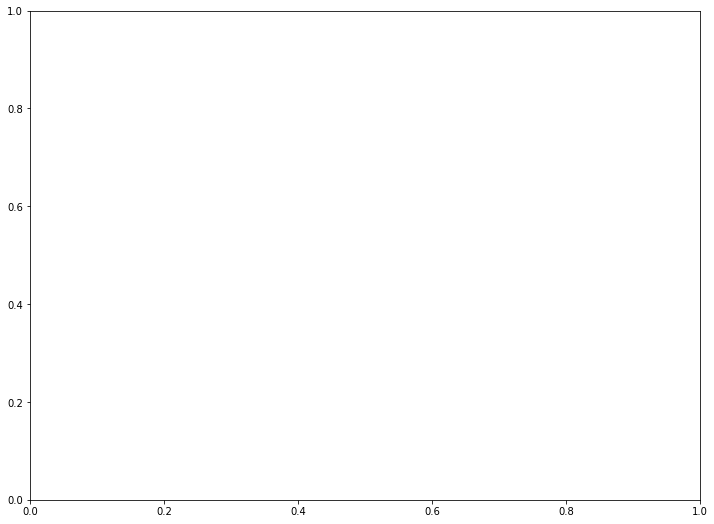

In [19]:
plt.figure(figsize=(12, 9))

plt.plot(global_tao_step)

plt.xlabel('Tempo')
plt.ylabel('Global tao')
plt.legend(['Adv wallet', 'Honest wallet'])
plt.title("Change in global tao over time")

In [340]:
# conviction 
# daily tao, SN owner take, parent take, validator split
expected_daily_return = 7200 * 0.82 * 0.5 * 0.82 * tao_portion


2686.32

In [344]:
0.18 / 0.82 / 0.5


0.43902439024390244

In [345]:
0.43 * 0.1 * 7_000_000

301000.0

Text(0.5, 1.0, 'Change in conviction over time, 30 days, lock_duration/7200')

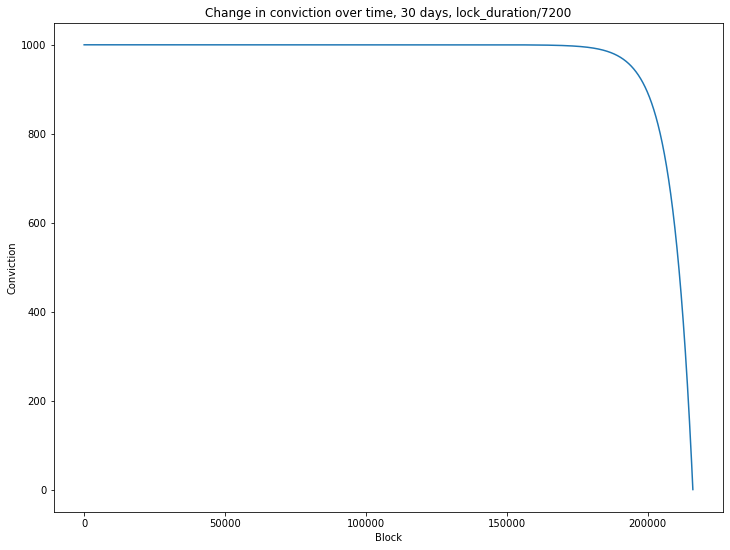

In [349]:
import math 
lock_amount = 1000

scores = []
for lock_duration in range(7200 * 30, 0, -1): # end block - curent block
    score = lock_amount * (1 - math.e**(-lock_duration / (7200)))
    scores.append(score)

plt.figure(figsize=(12, 9))

plt.plot(scores)

plt.xlabel('Block')
plt.ylabel('Conviction')
plt.title("Change in conviction over time, 30 days, lock_duration/7200")

just to brain storm, 

based on some dtao characteristic,
=== dtao === 
- emission **within** a SN unchanged

- prices of alpha changes with how much tao & alpha do we have in the alpha pool

- emission per block: 
--- globally: 
------ +1 tao 
------ +1 alpha 
--- locally: 
------ +0.3 tao goes to the alpha pool  (assuming the alpha SN currently have 30% of the tao in its pool), 
------ +0.7 tao goes to non-alpha pool
------ +0.5 alpha goes to the alpha pool 
------ + 0.5 alpha become the incentive/divident

- user action1 : buying alpha with 1 tao -> -1 tao in the pool & supply of alpha increase -> price of alpha decrease based on calculation from the pool

- user action2 : selling alpha with 1 tao -> +1 tao in the pool & supply of alpha decrease -> price of alpha increase  based on the calculation from the pool

=== stao ===
- emission within a SN keep unchanged 

- price of alpha = price of tao, ie. 1 tao = 1 alpha = 1 beta etc 

-user action1 : buying alpha with 1 tao-> cause 1 tao = 1 alpha -> -1 tao in the pool +1 alpha in the pool -> emission to the SN should goes up

-user action1 : selling alpha with 1 tao-> cause 1 tao = 1 alpha -> +1 tao in the pool -1 alpha in the pool -> emission to the SN should goes down

- emission per block: 
--- globally 
------ +1 tao
------ +x alpha

--- locally
------ emission of tao to each SN should be proportional to the amount of alpha in each pool; 
------ +0.3 tao goes to the alpha pool (assuming the alpha SN currently have 30% of the tao in its pool) 
------ +0.7 tao goes to the non-alpha pool
------ + 0.3 alpha goes to the alpha pool (so that 1 tao still = 1 alpha)
------ (not sure) +0.3 alpha become the incentive/divident
------ so x = 0.3 + 0.3 alpha in the global emission  

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

class Pools():
    def __init__(self, pools, tao_outstanding, lock, sim):
        self.pools = pools 
        self.tao_outstanding = tao_outstanding - lock * len(pools)
        tao_mc = (sum([ p.tao_in for p in pools ]) + tao_outstanding)
        self.market_cap = [[ p.market_cap for p in pools ] + [tao_mc]]
        self.price = [[p.price for p in pools]]
        self.tao_in = [[p.tao_in for p in pools]]
        self.alpha_in = [[p.alpha_in for p in pools]]
        self.alpha_out = [[p.alpha_out for p in pools]]
        self._sim = sim

    @property
    def price_df(self): return pd.DataFrame(pools.price, columns = [ f"p{netuid}"for netuid in range(len(pools.pools)) ])
    
    @property
    def tao_in_df(self): return pd.DataFrame(pools.tao_in_df, columns = [ f"p{netuid}"for netuid in range(len(pools.pools)) ])
    
    @property
    def alpha_in_df(self): return pd.DataFrame(pools.alpha_in_df, columns = [ f"p{netuid}"for netuid in range(len(pools.pools)) ])

    @property
    def alpha_out_df(self): return pd.DataFrame(pools.alpha_out_df, columns = [ f"p{netuid}"for netuid in range(len(pools.pools)) ])
    
    @property
    def market_cap_df(self): 
        mc = pd.DataFrame(pools.market_cap, columns = [ f"p{netuid}"for netuid in range(len(pools.pools)) ] + ['TAO'])
        mc['market_cap_ratio'] = mc.loc[:, ['p' in idx for idx in mc.columns]].sum(axis = 1) / mc.TAO
        return mc 
        
    def agg_stat(self):
        tao_mc = (sum([ p.tao_in for p in self.pools ]) + self.tao_outstanding) 
        self.price += [[ p.price for p in self.pools ]]
        self.tao_in += [[ p.tao_in for p in self.pools ]]
        self.alpha_in += [[ p.alpha_in for p in self.pools ]]
        self.alpha_out += [[ p.alpha_out for p in self.pools ]]
        self.market_cap += [[ p.market_cap for p in self.pools ] + [tao_mc]]


## Choosing alpha out

In [16]:
import numpy as np

def sim(self, n_days, alpha_in, alpha_out):
    n_blocks = n_days * 7200
    
    for block in range(n_blocks): 
        # The coinbase injection based on the sum of the prices.
        sum_prices = sum( [p.price for p in self.pools] )
        for i, p in enumerate(self.pools):
            if sum_prices >= 1.0:
                p.inject( tao_in = 0, alpha_in = alpha_in, alpha_out = alpha_out )
            
            else:
                p.inject( tao_in = (p.price/sum_prices), alpha_in = 0, alpha_out = alpha_out) 
        
        self.agg_stat()    

# trials = {}

for alpha_out in np.arange(1, 5, 0.3):
    pools = [
        Pool (500, 1000, 1000),
        Pool (300, 1000, 1000),
        Pool (200, 1000, 1000),
    ]
    
    pools = Pools(pools, tao_outstanding = 10_000_000, lock = 1000, sim = sim )
    
    pools.sim(pools, n_days = 365, alpha_in = 1, alpha_out = alpha_out)
    
    trials[alpha_out] = pools

<function matplotlib.pyplot.legend(*args, **kwargs)>

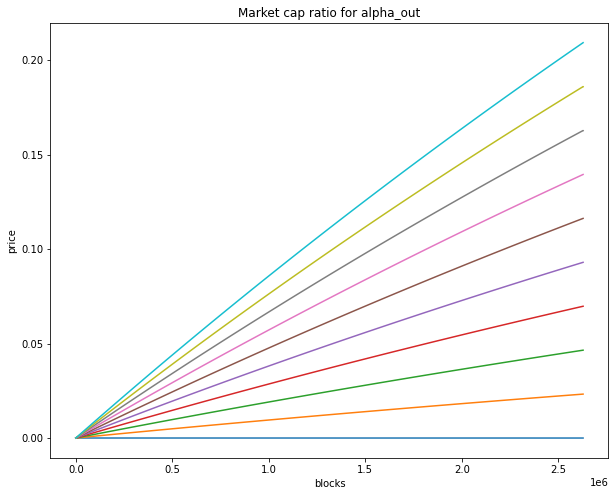

In [15]:
fig, ax = plt.subplots(figsize=(20, 16))
for alpha_out, pools in trials.items():
    plt.plot(pools.market_cap_df.market_cap_ratio, label = alpha_out)
plt.title(f'Market cap ratio for alpha_out')
plt.xlabel('blocks')
plt.ylabel('price')
plt.legend()

## Price manipulation

In [ ]:
def sim(self, n_days, alpha_in, alpha_out):
    n_blocks = n_days * 7200
    
    for block in range(n_blocks): 
        # The coinbase injection based on the sum of the prices.
        sum_prices = sum( [p.price for p in self.pools] )
        for i, p in enumerate(self.pools):
            if sum_prices >= 1.0:
                p.inject( tao_in = 0, alpha_in = alpha_in, alpha_out = alpha_out )
            
            else:
                p.inject( tao_in = (p.price/sum_prices), alpha_in = 0, alpha_out = alpha_out) 
        
        self.agg_stat()    

pools = [
    Pool (500, 1000, 1000),
    Pool (300, 1000, 1000),
    Pool (200, 1000, 1000),
]

pools = Pools(pools, tao_outstanding = 10_000_000, lock = 1000, sim = sim )

pools.sim(pools, n_days = 365, alpha_in = 1, alpha_out = 1)

## Inf SNs 

In [28]:
p = Pool(1000, 10_000, 10_100)
print(p.price) 
p.inject(7200/10, 7200, 7200)
print(p.price)

0.1
0.1


P( 1720.0, 17200, 17300, 0.1)

In [29]:
p.simsell(991)

93.70128085316924